In [1]:
import sys
import os

# Adiciona o diretório raiz do projeto ao sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [25]:
import pandas as pd
from config import settings
from scripts.AutoClusterHPO import AutoClusterHPO
from scripts.PCATransformer import PCATransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np

In [3]:
df_pof_domicilio = pd.read_csv(settings.DADOS_CSV, sep=',')

In [8]:
quanti_cols = ['Qtd de banheiros exclusivos',
 'Rendimento mensal mínimo geral (R$)', 'Qtd de cômodos',
 'Valor em reais (R$) do rendimento bruto',
 'Valor em reais (R$) de despesa individual',
 'Rendimento mensal mínimo p\\ alimentação (R$)',
 'Valor em reais (R$) de despesa coletiva']

quali_cols = ['A rua onde se localiza é pavimentada?', 'Situação do Domicílio',
 'A água é aquecida por energia elétrica?',
 'Utiliza-se lenha ou carvão na preparação de alimentos?',
 'Utiliza-se energia elétrica na preparação de alimentos?',
 'Material do telhado', 'Material do piso',
 'A água é aquecida por energia solar?',
 'Tipo de escoadouro sanitário',
 'A água é aquecida por lenha ou carvão?',
 'A água é aquecida por gás?', 'Tipo de chegada da água',
 'A água é aquecida por outra forma?',
 'O serviço de correios é realizado:', 'Tipo do domicílio']

# Inicializa o scaler
scaler = StandardScaler()

# 2. Separar features (X) e alvo (y)
X = df_pof_domicilio[quanti_cols + quali_cols]
y = df_pof_domicilio['Aluguel Estimado (Faixa)']

# 3. PRÉ-PROCESSAMENTO - Parte 1: One-Hot Encoding
# Aplicar em colunas categóricas para evitar multicolinearidade
X_encoded = pd.get_dummies(X, columns=df_pof_domicilio[quali_cols].columns, drop_first=True)

X_final = X_encoded.copy()

X_final[quanti_cols] = scaler.fit_transform(X_final[quanti_cols])

In [11]:
# Dividindo os dados em 70% para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

In [12]:
# 1. Crie uma instância do modelo
# Vamos começar com uma profundidade máxima de 5 e usar o critério Gini
dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)

# 2. Treine o modelo com os dados de treinamento
dtc.fit(X_train, y_train)

# 3. Faça as previsões no conjunto de teste
y_predict = dtc.predict(X_test)

In [ ]:
report = classification_report(y_test, y_predict)
print(report)

                 precision    recall  f1-score   support

1 - Muito Baixo       0.65      0.56      0.60      3250
      2 - Baixo       0.36      0.61      0.45      3492
      3 - Médio       0.00      0.00      0.00      2050
       4 - Alto       0.34      0.36      0.35      2632
 5 - Muito Alto       0.60      0.56      0.58      2471

       accuracy                           0.45     13895
      macro avg       0.39      0.42      0.40     13895
   weighted avg       0.41      0.45      0.42     13895



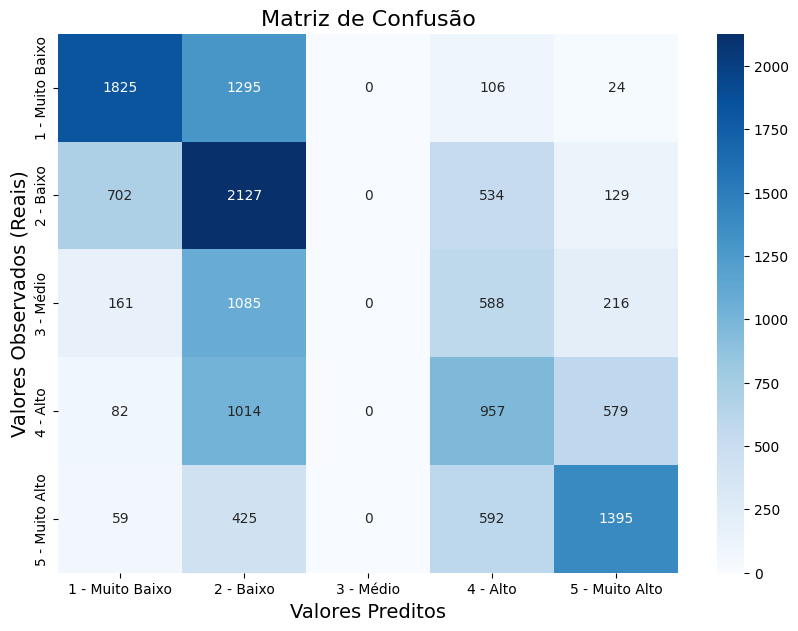

In [14]:
# 1. Gere a Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_predict)

# 2. Obtenha os rótulos das classes
# É importante garantir que os rótulos estejam na ordem correta
class_labels = np.unique(np.concatenate((y_test, y_predict)))

# 3. Crie a visualização com Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix, 
    annot=True,     # anota os números em cada célula
    fmt='d',        # formata os números como inteiros
    cmap='Blues',   # define o esquema de cores
    xticklabels=class_labels, 
    yticklabels=class_labels
)

# 4. Adicione os títulos dos eixos para clareza
plt.xlabel('Valores Preditos', fontsize=14)
plt.ylabel('Valores Observados (Reais)', fontsize=14)
plt.title('Matriz de Confusão', fontsize=16)
plt.show()

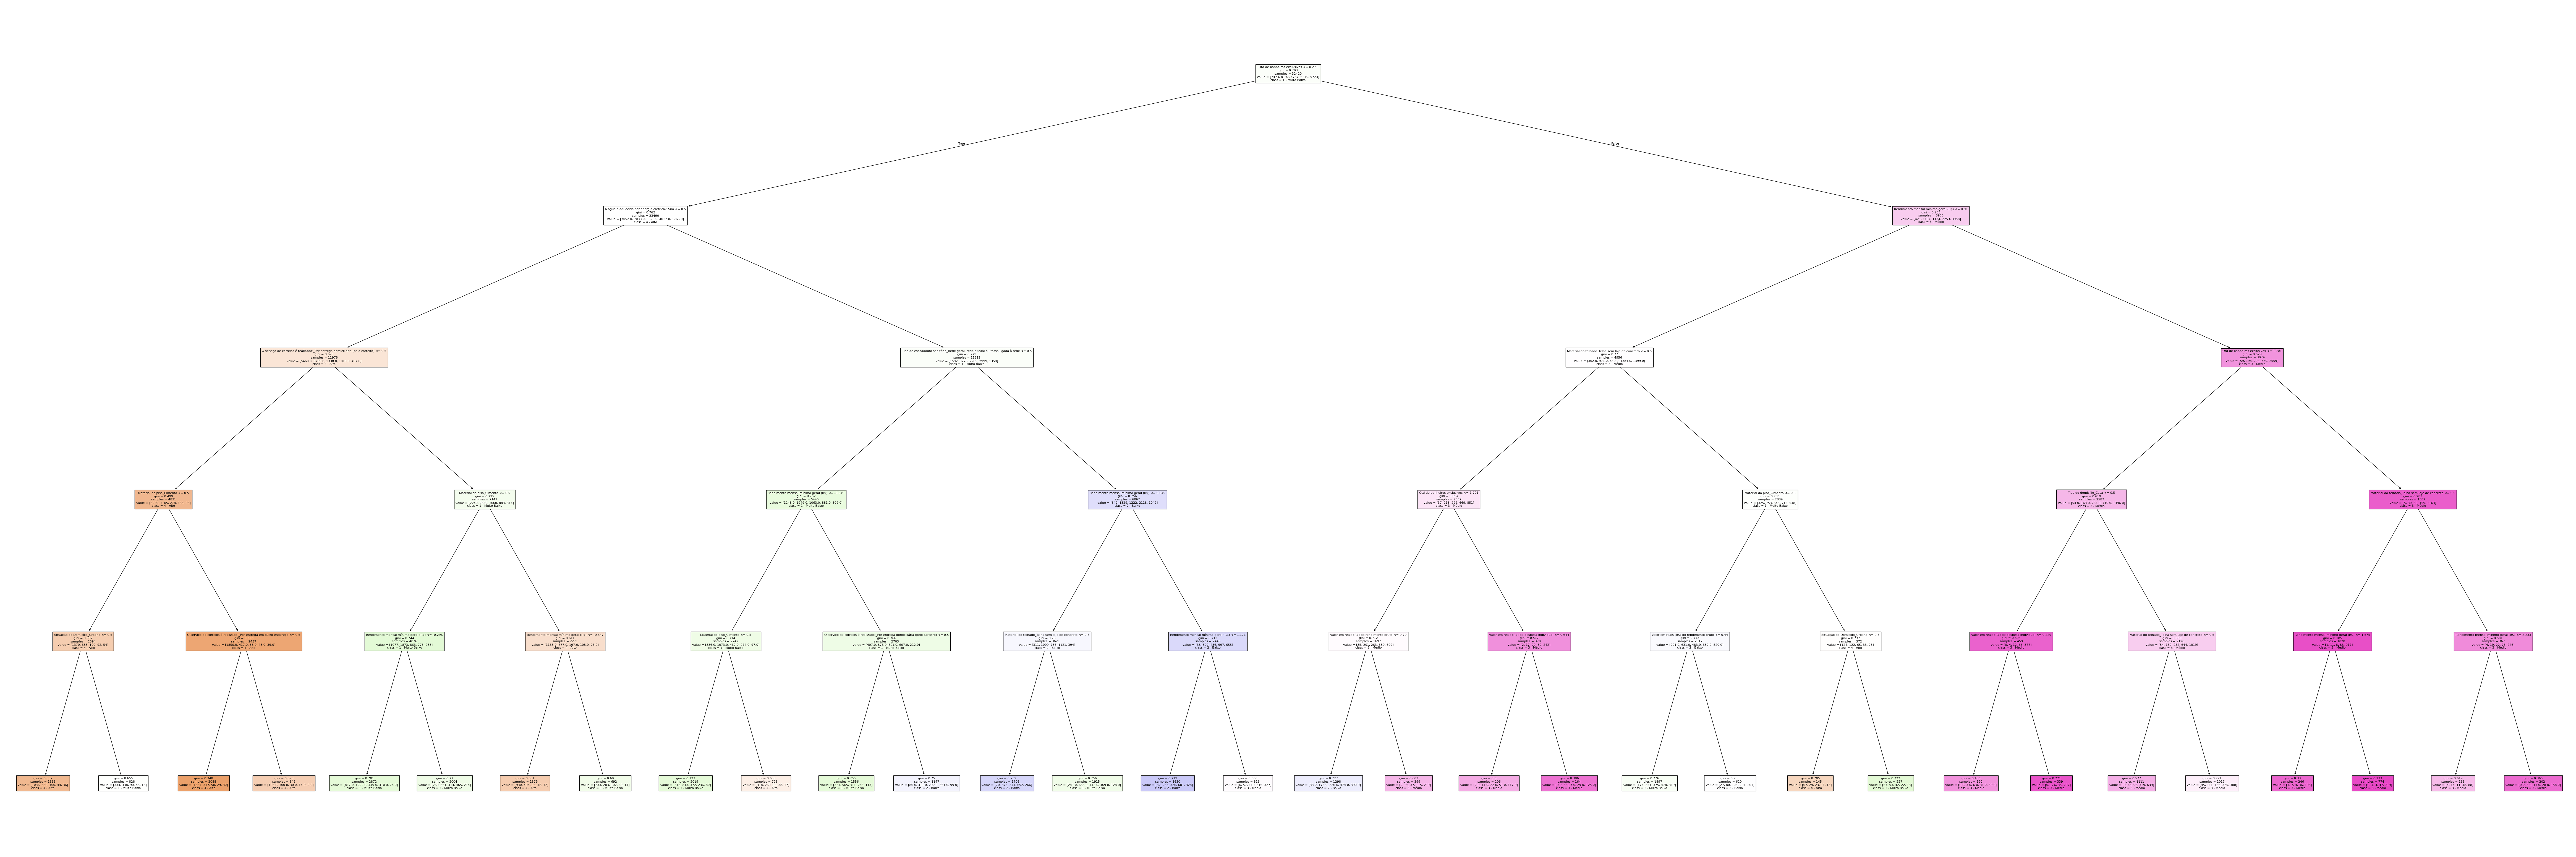

In [24]:
# Crie a figura
plt.figure(figsize=(120, 40))

# Plote a árvore adicionando o parâmetro fontsize
plot_tree(
    dtc, 
    feature_names=X_final.columns, 
    class_names=['4 - Alto', '1 - Muito Baixo', '5 - Muito Alto', '2 - Baixo', '3 - Médio'], 
    filled=True,
    fontsize=8  # <-- PARÂMETRO ADICIONADO AQUI
)

# Mostre o gráfico
plt.show()